In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from collections import defaultdict, deque
import heapq

# Build G_0 as a directed version of the undirected graph

In [8]:
def build_directed_graph_with_ego(edge_path, ego_id=0, p=0.1):
    """
    Build a directed graph from a .edges file:
    - Each undirected edge (u, v) is added as two directed edges u→v and v→u;
    - The ego node (default ID: 0) is connected to all nodes (0→v and v→0);
    - Each edge is assigned a propagation probability p.
    """
    G = nx.DiGraph()

    # Step 1: Add bidirectional edges for each undirected edge
    with open(edge_path) as f:
        for line in f:
            u, v = map(int, line.strip().split())
            G.add_edge(u, v, weight=p)
            G.add_edge(v, u, weight=p)

    # Step 2: Add ego node and connect it to all other nodes
    neighbors = list(G.nodes())  # Current nodes are friends of the ego
    for v in neighbors:
        G.add_edge(ego_id, v, weight=p)
        G.add_edge(v, ego_id, weight=p)

    return G

G_0 = build_directed_graph_with_ego("./facebook/0.edges")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 334
Edges: 5704


# Select 5 seed nodes based on feature activity (100 IC simulations, p=0.1)

In [9]:
def select_seeds_by_feature_activity(csv_path, k):
    """
    Read node feature activity scores (number of 1s) from the feature table,
    and return the top-k node_ids as seed nodes.
    """
    df = pd.read_csv(csv_path)
    
    # Compute each node's activity score (sum over all columns except node_id)
    df["activity_score"] = df.drop(columns=["node_id"]).sum(axis=1)
    
    # Select top-k most active nodes
    topk = df.sort_values(by="activity_score", ascending=False).head(k)
    
    return topk["node_id"].tolist()

def run_ic(G, seeds, p=0.1, steps=100):
    """
    Run the Independent Cascade (IC) model on directed graph G.
    Repeats the simulation 'steps' times and returns the average spread.
    - G: networkx.DiGraph
    - seeds: list[int], initial seed nodes
    - p: propagation probability (default uses edge 'weight')
    - steps: number of Monte Carlo simulations
    Returns: average number of activated nodes
    """
    total_spread = []

    for _ in range(steps):
        activated = set(seeds)
        newly_activated = set(seeds)

        while newly_activated:
            new_active = set()
            for node in newly_activated:
                for neighbor in G.successors(node):  # Only consider outgoing edges
                    if neighbor not in activated:
                        edge_p = G[node][neighbor].get("weight", p)
                        if random.random() <= edge_p:
                            new_active.add(neighbor)
            newly_activated = new_active
            activated.update(new_active)

        total_spread.append(len(activated))

    return sum(total_spread) / steps


seeds = select_seeds_by_feature_activity("facebook_features_with_ego.csv", k=5)
print("Seed set:", seeds)

# G is the previously constructed graph
# seeds are selected using the feature activity method
avg_spread = run_ic(G_0, seeds, p=0.1, steps=100)
print("Avg Spread:", avg_spread)


seed sets： [252, 0, 339, 323, 170]
Avg Effection： 180.04


# Select 5 seed nodes using the CELF algorithm (100 IC simulations, p=0.1)

In [10]:
def celf(G, k, p=0.1, steps=100):
    """
    Select k seed nodes from graph G using the CELF algorithm.
    - G: Directed graph with propagation probabilities
    - k: Number of seeds to select
    - p: Propagation probability
    - steps: Number of Monte Carlo simulations
    Returns: List of selected seed nodes
    """

    # Step 1: Initialize — evaluate influence of each node as a single seed
    queue = []
    for node in G.nodes():
        spread = run_ic(G, [node], p=p, steps=steps)
        heapq.heappush(queue, (-spread, node, 0))  # (-marginal gain, node, last updated)

    selected = []
    spread_cache = {}
    step = 1

    while len(selected) < k:
        spread_neg, node, last_updated = heapq.heappop(queue)

        if last_updated == len(selected):
            selected.append(node)
            spread_cache[node] = -spread_neg
        else:
            # Recalculate marginal gain with current seed set
            current_spread = run_ic(G, selected + [node], p=p, steps=steps)
            marginal_gain = current_spread - sum(spread_cache.values())
            heapq.heappush(queue, (-marginal_gain, node, len(selected)))

    return selected

celf_seeds = celf(G_0, k=5, p=0.1, steps=100)
print("Seed nodes selected by CELF:", celf_seeds)

# Evaluate average spread of CELF-selected seeds
celf_spread = run_ic(G_0, celf_seeds, p=0.1, steps=100)
print("Avg spread (CELF):", celf_spread)


CELF 选出的种子节点： [170, 4, 319, 99, 46]
CELF 平均感染人数： 186.9


# Visualize one round of propagation based on the seed sets selected by both methods

In [11]:
# === Load graph structure and circle information ===
# G = nx.read_edgelist("facebook_with_ego.edgelist", nodetype=int, create_using=nx.DiGraph())
df_circles = pd.read_csv("ego_circles_expanded.csv")

# Build a mapping: member_id -> circle_name
circle_map = defaultdict(set)
for _, row in df_circles.iterrows():
    circle_map[row["member_id"]].add(row["circle_name"])

# Assign a color to each circle
circle_names = sorted(set(df_circles["circle_name"]))
circle_colors = {c: f"C{i%10}" for i, c in enumerate(circle_names)}

# Define node colors (default to gray)
def get_node_color(node):
    if node in circle_map:
        # If a node is in multiple circles, pick one circle's color
        return circle_colors[sorted(circle_map[node])[0]]
    return "#cccccc"  # Gray for nodes not in any circle

def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)

    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier

    return activated

def draw_spread(G, seeds, infected, title):
    pos = nx.spring_layout(G, seed=42)
    node_colors = []
    node_sizes = []

    for node in G.nodes():
        if node in seeds:
            node_colors.append("#ff0000")  # Red for seed nodes
            node_sizes.append(150)
        elif node in infected:
            node_colors.append(get_node_color(node))
            node_sizes.append(60)
        else:
            node_colors.append("#dddddd")
            node_sizes.append(10)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.85)
    nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3)
    plt.title(title)
    plt.axis("off")
    plt.show()


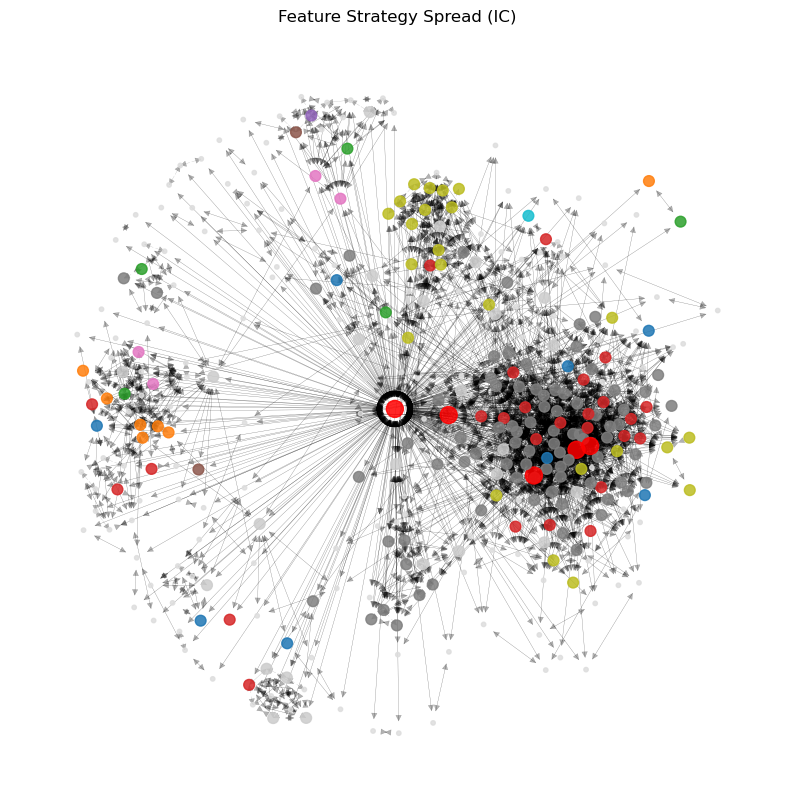

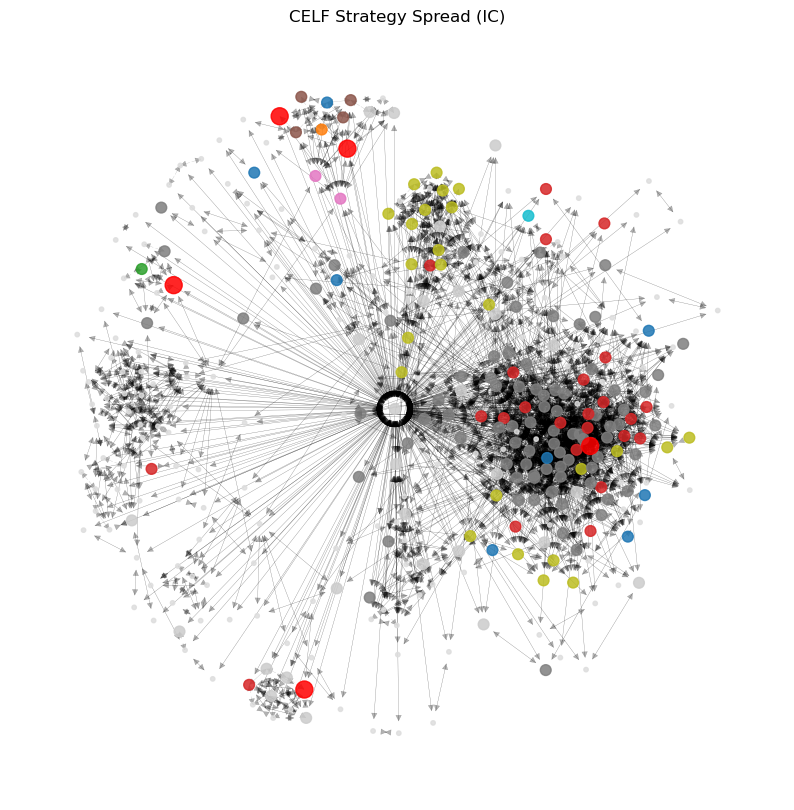

In [12]:
# Two seed sets (replace with your actual seeds)
feature_seeds = [252, 0, 339, 323, 170]
celf_seeds = [170, 4, 319, 99, 46]

# Run one round of Independent Cascade (IC) diffusion
infected_feature = run_ic_once(G_0, feature_seeds, p=0.1)
infected_celf = run_ic_once(G_0, celf_seeds, p=0.1)

# Visualize the spread results for both strategies
draw_spread(G_0, feature_seeds, infected_feature, "Feature Strategy Spread (IC)")
draw_spread(G_0, celf_seeds, infected_celf, "CELF Strategy Spread (IC)")


# Observation from the Graph
## Conclusion: The feature activity method tends to select seeds in densely connected regions, but lacks consideration for boundary nodes, which are better handled by the CELF algorithm.

# Compare different algorithms across 10 ego networks

## Feature V.S. CELF

In [79]:
# === Configuration parameters ===
data_path = "facebook"
p = 0.1
steps = 100
num_seeds = 5

# === Scan available ego IDs ===
ego_ids = sorted([int(f.split(".")[0]) for f in os.listdir(data_path) if f.endswith(".feat")])

def load_features(ego_id):
    feat = np.loadtxt(f"{data_path}/{ego_id}.feat")
    node_ids = feat[:, 0].astype(int)
    features = feat[:, 1:]
    ego_feat = np.loadtxt(f"{data_path}/{ego_id}.egofeat").astype(int)
    with open(f"{data_path}/{ego_id}.featnames") as f:
        featnames = [line.strip().split(" ", 1)[1] if " " in line else f"feature_{i}" for i, line in enumerate(f)]
    df_friends = pd.DataFrame(features, columns=featnames)
    df_friends.insert(0, "node_id", node_ids)
    df_ego = pd.DataFrame([ego_feat], columns=featnames)
    df_ego.insert(0, "node_id", [ego_id])
    return pd.concat([df_ego, df_friends], ignore_index=True)

def build_graph(ego_id):
    G = nx.DiGraph()
    with open(f"{data_path}/{ego_id}.edges") as f:
        for line in f:
            u, v = map(int, line.strip().split())
            G.add_edge(u, v, weight=p)
            G.add_edge(v, u, weight=p)
    for node in list(G.nodes()):
        G.add_edge(ego_id, node, weight=p)
        G.add_edge(node, ego_id, weight=p)
    return G

def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    total = 0
    for _ in range(steps):
        infected = run_ic_once(G, seeds, p)
        total += len(infected)
    return total / steps

def celf(G, k, p=0.1, steps=100):
    """
    Standard CELF implementation (with lazy updates and heap optimization)
    """
    queue = []
    for node in G.nodes():
        spread = run_ic(G, [node], p=p, steps=steps)
        heapq.heappush(queue, (-spread, node, 0))  # (-gain, node, last_updated)

    selected = []
    spread_cache = {}
    while len(selected) < k:
        spread_neg, node, last_updated = heapq.heappop(queue)
        if last_updated == len(selected):
            selected.append(node)
            spread_cache[node] = -spread_neg
        else:
            current_spread = run_ic(G, selected + [node], p=p, steps=steps)
            marginal_gain = current_spread - sum(spread_cache.values())
            heapq.heappush(queue, (-marginal_gain, node, len(selected)))
    return selected

# === Main loop ===
for ego_id in ego_ids:
    print(f"\n▶ Ego {ego_id} ===============================")
    df_feat = load_features(ego_id)
    G = build_graph(ego_id)
    graph_size = len(G)

    # Feature-based strategy
    df_feat["activity"] = df_feat.drop(columns=["node_id"]).sum(axis=1)
    seeds_feat = df_feat.sort_values(by="activity", ascending=False)["node_id"].head(num_seeds).tolist()
    spread_feat = run_ic(G, seeds_feat, steps=steps, p=p)

    print(f"[Feature] Seeds: {seeds_feat}")
    print(f"[Feature] Avg Infected: {round(spread_feat, 2)} | Coverage: {round((spread_feat/graph_size)*100, 2)}%")

    # CELF strategy
    seeds_celf = celf(G, num_seeds, p=p, steps=steps)
    spread_celf = run_ic(G, seeds_celf, steps=steps, p=p)

    print(f"[CELF]    Seeds: {seeds_celf}")
    print(f"[CELF]    Avg Infected: {round(spread_celf, 2)} | Coverage: {round((spread_celf/graph_size)*100, 2)}%")



▶ Ego 0 ===============================
[Feature] Seeds: [252, 0, 339, 323, 170]
[Feature] Avg Infected: 178.92 | Coverage: 53.57%
[CELF]    Seeds: [199, 226, 30, 28, 326]
[CELF]    Avg Infected: 184.93 | Coverage: 55.37%

▶ Ego 107 ===============================
[Feature] Seeds: [930, 1549, 917, 1029, 1473]
[Feature] Avg Infected: 882.39 | Coverage: 85.26%
[CELF]    Seeds: [1614, 1379, 1016, 1045, 1208]
[CELF]    Avg Infected: 885.86 | Coverage: 85.59%

▶ Ego 348 ===============================
[Feature] Seeds: [439, 367, 348, 569, 523]
[Feature] Avg Infected: 169.62 | Coverage: 75.39%
[CELF]    Seeds: [428, 453, 379, 406, 572]
[CELF]    Avg Infected: 172.97 | Coverage: 76.88%

▶ Ego 414 ===============================
[Feature] Seeds: [604, 579, 394, 641, 654]
[Feature] Avg Infected: 115.98 | Coverage: 76.81%
[CELF]    Seeds: [378, 647, 659, 670, 612]
[CELF]    Avg Infected: 119.76 | Coverage: 79.31%

▶ Ego 686 ===============================
[Feature] Seeds: [747, 828, 723, 688, 7

## Degree Discount

In [81]:
# === Parameter settings ===
data_path = "facebook"
num_seeds = 5
steps = 100
p = 0.1

# Automatically collect available ego IDs
ego_ids = sorted([int(f.split('.')[0]) for f in os.listdir(data_path) if f.endswith(".feat")])

# === Utility functions ===

def build_graph(ego_id):
    G = nx.DiGraph()
    with open(f"{data_path}/{ego_id}.edges") as f:
        for line in f:
            u, v = map(int, line.strip().split())
            G.add_edge(u, v, weight=p)
            G.add_edge(v, u, weight=p)
    for node in list(G.nodes()):
        G.add_edge(ego_id, node, weight=p)
        G.add_edge(node, ego_id, weight=p)
    return G

def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    return np.mean([len(run_ic_once(G, seeds, p)) for _ in range(steps)])

def degree_discount(G, k, p=0.1):
    S = set()
    d = {u: len(list(G.neighbors(u))) for u in G.nodes()}
    t = {u: 0 for u in G.nodes()}
    dd = d.copy()
    seeds = []
    for _ in range(k):
        u = max(dd, key=dd.get)
        seeds.append(u)
        S.add(u)
        for v in G.neighbors(u):
            t[v] += 1
            dd[v] = d[v] - 2 * t[v] - (d[v] - t[v]) * t[v] * p
        dd[u] = -1
    return seeds

# === Main loop ===

for ego_id in ego_ids:
    print(f"\n▶ Ego {ego_id} ===============================")
    G = build_graph(ego_id)
    seeds_dd = degree_discount(G, num_seeds, p=p)
    avg_dd = run_ic(G, seeds_dd, p=p, steps=steps)
    print(f"[DD]      Seeds: {seeds_dd}")
    print(f"[DD]      Avg Infected: {avg_dd:.2f} | Coverage: {avg_dd / G.number_of_nodes() * 100:.2f}%")



▶ Ego 0 ===============================
[DD]      Seeds: [0, 56, 0, 56, 0]
[DD]      Avg Infected: 179.45 | Coverage: 53.73%

▶ Ego 107 ===============================
[DD]      Seeds: [107, 1888, 107, 1888, 107]
[DD]      Avg Infected: 883.73 | Coverage: 85.38%

▶ Ego 348 ===============================
[DD]      Seeds: [348, 376, 348, 376, 348]
[DD]      Avg Infected: 168.44 | Coverage: 74.86%

▶ Ego 414 ===============================
[DD]      Seeds: [414, 376, 414, 376, 414]
[DD]      Avg Infected: 115.33 | Coverage: 76.38%

▶ Ego 686 ===============================
[DD]      Seeds: [686, 828, 686, 828, 686]
[DD]      Avg Infected: 116.12 | Coverage: 68.71%

▶ Ego 698 ===============================
[DD]      Seeds: [698, 856, 698, 856, 698]
[DD]      Avg Infected: 24.15 | Coverage: 38.95%

▶ Ego 1684 ===============================
[DD]      Seeds: [1684, 2839, 1684, 2839, 1684]
[DD]      Avg Infected: 631.62 | Coverage: 80.26%

▶ Ego 1912 ===============================
[DD]   

## DD+CELF

In [84]:
def hybrid_dd_celf_lazy(G, k=5, N=20, p=0.1, steps=100):
    """
    Hybrid strategy: use Degree Discount to select N candidates,
    then apply CELF with lazy updates to choose k final seeds.
    """

    # === Step 1: Degree Discount candidate pool ===
    d = {u: len(list(G.neighbors(u))) for u in G.nodes()}
    t = {u: 0 for u in G.nodes()}
    dd = d.copy()
    candidate_pool = []
    used = set()

    while len(candidate_pool) < N:
        u = max(dd, key=dd.get)
        if u in used:
            dd[u] = -1
            continue
        candidate_pool.append(u)
        used.add(u)
        for v in G.neighbors(u):
            t[v] += 1
            dd[v] = d[v] - 2 * t[v] - (d[v] - t[v]) * t[v] * p
        dd[u] = -1

    # === Step 2: CELF with Lazy Update ===
    queue = []
    spread_cache = {}
    for node in candidate_pool:
        spread = run_ic(G, [node], p=p, steps=steps)
        spread_cache[node] = spread
        queue.append([-spread, node, 0])  # [negative gain, node, last update step]

    heapq.heapify(queue)
    selected = []
    selected_set = set()

    while len(selected) < k:
        spread_neg, node, last_updated = heapq.heappop(queue)
        if node in selected_set:
            continue
        if last_updated == len(selected):
            selected.append(node)
            selected_set.add(node)
        else:
            new_spread = run_ic(G, selected + [node], p=p, steps=steps)
            marginal_gain = new_spread - sum(spread_cache[n] for n in selected)
            spread_cache[node] = marginal_gain
            heapq.heappush(queue, [-marginal_gain, node, len(selected)])

    return selected

# === Main loop across all ego networks ===
for ego_id in ego_ids:
    print(f"\n▶ Ego {ego_id} ===============================")
    G = build_graph(ego_id)
    seeds_hybrid = hybrid_dd_celf_lazy(G, k=num_seeds, N=20, p=p, steps=steps)
    avg_infected = run_ic(G, seeds_hybrid, p=p, steps=steps)
    print(f"[Hybrid] Seeds: {seeds_hybrid}")
    print(f"[Hybrid] Avg Infected: {avg_infected:.2f} | Coverage: {avg_infected / G.number_of_nodes() * 100:.2f}%")



▶ Ego 0 ===============================
[Hybrid] Seeds: [67, 175, 41, 320, 258]
[Hybrid] Avg Infected: 185.10 | Coverage: 55.42%

▶ Ego 107 ===============================
[Hybrid] Seeds: [1359, 897, 1591, 1663, 1358]
[Hybrid] Avg Infected: 882.89 | Coverage: 85.30%

▶ Ego 348 ===============================
[Hybrid] Seeds: [412, 376, 369, 463, 462]
[Hybrid] Avg Infected: 169.58 | Coverage: 75.37%

▶ Ego 414 ===============================
[Hybrid] Seeds: [483, 600, 643, 578, 373]
[Hybrid] Avg Infected: 118.94 | Coverage: 78.77%

▶ Ego 686 ===============================
[Hybrid] Seeds: [686, 793, 833, 822, 779]
[Hybrid] Avg Infected: 118.69 | Coverage: 70.23%

▶ Ego 698 ===============================
[Hybrid] Seeds: [698, 856, 881, 776, 867]
[Hybrid] Avg Infected: 26.87 | Coverage: 43.34%

▶ Ego 1684 ===============================
[Hybrid] Seeds: [1684, 2944, 3434, 2724, 3136]
[Hybrid] Avg Infected: 629.80 | Coverage: 80.03%

▶ Ego 1912 ===============================
[Hybrid] Seed

In [85]:
# === Parameter Settings ===
data_path = "facebook"
num_seeds = 5
steps = 100
p = 0.1
num_rr_sets = 1000

ego_ids = sorted([int(f.split('.')[0]) for f in os.listdir(data_path) if f.endswith(".feat")])

# === Utility Functions ===

def build_graph(ego_id):
    G = nx.DiGraph()
    with open(f"{data_path}/{ego_id}.edges") as f:
        for line in f:
            u, v = map(int, line.strip().split())
            G.add_edge(u, v, weight=p)
            G.add_edge(v, u, weight=p)
    for node in list(G.nodes()):
        G.add_edge(ego_id, node, weight=p)
        G.add_edge(node, ego_id, weight=p)
    return G

def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    return np.mean([len(run_ic_once(G, seeds, p)) for _ in range(steps)])

# === IMM Core ===

def generate_rr_set(G, p=0.1):
    start_node = random.choice(list(G.nodes()))
    rr_set = set()
    visited = set()
    queue = deque([start_node])
    visited.add(start_node)

    while queue:
        u = queue.popleft()
        rr_set.add(u)
        for v in G.predecessors(u):
            if v not in visited and random.random() <= G[v][u].get('weight', p):
                visited.add(v)
                queue.append(v)

    return rr_set

def imm(G, k=5, num_rr_sets=1000, p=0.1):
    rr_sets = [generate_rr_set(G, p) for _ in range(num_rr_sets)]

    cover_dict = defaultdict(set)
    for idx, rr in enumerate(rr_sets):
        for node in rr:
            cover_dict[node].add(idx)

    selected = set()
    covered = set()
    for _ in range(k):
        max_node = max((n for n in cover_dict if n not in selected),
                       key=lambda n: len(cover_dict[n] - covered), default=None)
        if max_node is None:
            break
        selected.add(max_node)
        covered |= cover_dict[max_node]

    return list(selected)

# === Main Execution Loop ===

for ego_id in ego_ids:
    print(f"\n▶ Ego {ego_id} ===============================")
    G = build_graph(ego_id)
    seeds = imm(G, k=num_seeds, num_rr_sets=num_rr_sets, p=p)
    avg = run_ic(G, seeds, p=p, steps=steps)
    print(f"[IMM] Seeds: {seeds}")
    print(f"[IMM] Avg Infected: {avg:.2f} | Coverage: {avg / G.number_of_nodes() * 100:.2f}%")



▶ Ego 0 ===============================
[IMM] Seeds: [0, 34, 175, 115, 89]
[IMM] Avg Infected: 187.20 | Coverage: 56.05%

▶ Ego 107 ===============================
[IMM] Seeds: [1505, 107, 979, 1045, 1240]
[IMM] Avg Infected: 885.35 | Coverage: 85.54%

▶ Ego 348 ===============================
[IMM] Seeds: [549, 454, 563, 467, 443]
[IMM] Avg Infected: 171.99 | Coverage: 76.44%

▶ Ego 414 ===============================
[IMM] Seeds: [610, 581, 647, 660, 414]
[IMM] Avg Infected: 120.89 | Coverage: 80.06%

▶ Ego 686 ===============================
[IMM] Seeds: [712, 686, 789, 791, 733]
[IMM] Avg Infected: 119.00 | Coverage: 70.41%

▶ Ego 698 ===============================
[IMM] Seeds: [769, 872, 889, 698, 895]
[IMM] Avg Infected: 27.52 | Coverage: 44.39%

▶ Ego 1684 ===============================
[IMM] Seeds: [3008, 2661, 2799, 3290, 3037]
[IMM] Avg Infected: 636.47 | Coverage: 80.87%

▶ Ego 1912 ===============================
[IMM] Seeds: [2052, 2439, 2255, 1967, 2168]
[IMM] Avg Infe

# Run experiments on the full graph

## IMM

In [9]:
# === Parameter Configuration ===
input_file = "facebook_combined.txt"
p = 0.1                  # Propagation probability
num_seeds = 40           # Number of seed nodes to select
num_rr_sets = 15000      # Number of RR sets to generate in IMM
steps = 100              # Number of IC simulation runs

# === Step 1: Build bidirectional graph ===
print("Loading graph...")
G = nx.DiGraph()
with open(input_file) as f:
    for line in f:
        u, v = map(int, line.strip().split())
        G.add_edge(u, v, weight=p)
        G.add_edge(v, u, weight=p)
print(f"✅ Graph loaded. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# === Step 2: Generate RR sets for IMM ===
def generate_rr_set(G, p=0.1):
    start = random.choice(list(G.nodes()))
    rr = set()
    visited = set([start])
    queue = deque([start])
    while queue:
        u = queue.popleft()
        rr.add(u)
        for v in G.predecessors(u):
            if v not in visited and random.random() <= G[v][u].get('weight', p):
                visited.add(v)
                queue.append(v)
    return rr

def imm(G, k=20, num_rr_sets=15000, p=0.1):
    print(f"Generating {num_rr_sets} RR sets...")
    rr_sets = [generate_rr_set(G, p) for _ in range(num_rr_sets)]
    cover_map = defaultdict(set)
    for i, rr in enumerate(rr_sets):
        for node in rr:
            cover_map[node].add(i)

    selected = set()
    covered = set()
    for _ in range(k):
        best_node = max((n for n in cover_map if n not in selected),
                        key=lambda n: len(cover_map[n] - covered), default=None)
        if best_node is None:
            break
        selected.add(best_node)
        covered |= cover_map[best_node]

    return list(selected)

# === Step 3: Simulate Independent Cascade process ===
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    return np.mean([len(run_ic_once(G, seeds, p)) for _ in range(steps)])

# === Step 4: Run IMM and evaluate performance ===
seeds = imm(G, k=num_seeds, num_rr_sets=num_rr_sets, p=p)
avg_spread = run_ic(G, seeds, p=p, steps=steps)
coverage = avg_spread / G.number_of_nodes() * 100

print("\n IMM result")
print(f"Seeds: {seeds}")
print(f"Avg Infected: {avg_spread:.2f} / {G.number_of_nodes()}")
print(f"Coverage: {coverage:.2f}%")


Loading graph...
✅ Graph loaded. Nodes: 4039, Edges: 176468
Generating 15000 RR sets...

 IMM result
Seeds: [3200, 386, 131, 3720, 3980, 143, 272, 3989, 155, 929, 4009, 686, 49, 4024, 4027, 64, 839, 328, 595, 3797, 2774, 1368, 3546, 91, 93, 3809, 613, 870, 742, 233, 2922, 107, 364, 1133, 3311, 1394, 116, 2421, 3066, 2431]
Avg Infected: 3099.93 / 4039
Coverage: 76.75%


# Degree Distribution

In [20]:
# === Parameter Configuration ===
input_file = "facebook_combined.txt"
p = 0.1
num_seeds = 40
steps = 100

# === Build a bidirectional directed graph ===
print("Loading graph...")
G = nx.DiGraph()
with open(input_file) as f:
    for line in f:
        u, v = map(int, line.strip().split())
        G.add_edge(u, v, weight=p)
        G.add_edge(v, u, weight=p)
print(f"Graph loaded. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# === Select top-k nodes with highest degrees ===
degree_dict = dict(G.degree())
top_k = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:num_seeds]
seeds = [node for node, _ in top_k]

# === IC model simulation functions ===
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= G[u][v].get('weight', p):
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    return np.mean([len(run_ic_once(G, seeds, p)) for _ in range(steps)])

# === Run the simulation and evaluate spread ===
avg_spread = run_ic(G, seeds, p=p, steps=steps)
coverage = avg_spread / G.number_of_nodes() * 100

print("\nDegree-based selection result")
print(f"Seeds: {seeds}")
print(f"Avg Infected: {avg_spread:.2f} / {G.number_of_nodes()}")
print(f"Coverage: {coverage:.2f}%")


 Loading graph...
 Graph loaded. Nodes: 4039, Edges: 176468

 Degree 排序结果
Seeds: [107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663, 1352, 2266, 483, 348, 1730, 1985, 1941, 2233, 2142, 1431, 1199, 1584, 2206, 1768, 2229, 2410, 2611, 1086, 1589, 2047, 2218, 2078, 1993, 2123, 1746, 2464, 1827, 2240, 2507, 2560]
Avg Infected: 2956.88 / 4039
Coverage: 73.21%


# Degree Discount

In [15]:
# === Parameter Configuration ===
input_file = "facebook_combined.txt"
p = 0.1
num_seeds = 40
steps = 100

# === Step 1: Build a directed graph with bidirectional edges ===
print("Loading graph...")
G = nx.DiGraph()
with open(input_file) as f:
    for line in f:
        u, v = map(int, line.strip().split())
        G.add_edge(u, v, weight=p)
        G.add_edge(v, u, weight=p)
print(f"Graph loaded. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# === Step 2: Degree Discount Algorithm ===
def degree_discount(G, k, p=0.1):
    S = set()
    d = {u: len(list(G.neighbors(u))) for u in G.nodes()}
    t = {u: 0 for u in G.nodes()}
    dd = d.copy()
    seeds = []

    while len(seeds) < k:
        u = max((n for n in dd if n not in S), key=lambda x: dd[x])
        seeds.append(u)
        S.add(u)
        for v in G.neighbors(u):
            t[v] += 1
            dd[v] = d[v] - 2 * t[v] - (d[v] - t[v]) * t[v] * p
        dd[u] = -1  # Explicitly mark as used
    return seeds

# === Step 3: Independent Cascade Model Simulation ===
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= G[u][v].get('weight', p):
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    return np.mean([len(run_ic_once(G, seeds, p)) for _ in range(steps)])

# === Step 4: Seed selection and spread evaluation ===
seeds = degree_discount(G, k=num_seeds, p=p)
avg_spread = run_ic(G, seeds, p=p, steps=steps)
coverage = avg_spread / G.number_of_nodes() * 100

# === Print result ===
print("\nDegree Discount result")
print(f"Seeds: {seeds}")
print(f"Avg Infected: {avg_spread:.2f} / {G.number_of_nodes()}")
print(f"Coverage: {coverage:.2f}%")


Loading graph...
Graph loaded. Nodes: 4039, Edges: 176468

 Degree Discount 结果
Seeds: [107, 1912, 1684, 3437, 0, 2543, 2347, 1888, 483, 1800, 348, 686, 1663, 2266, 2047, 2553, 1352, 2839, 2560, 2352, 2328, 3101, 414, 1730, 3363, 917, 896, 3830, 2294, 3291, 136, 2552, 3090, 1431, 2863, 1459, 2951, 2520, 2509, 376]
Avg Infected: 3048.36 / 4039
Coverage: 75.47%


# Generate feature .csv

In [4]:
def combine_all_feat(folder="facebook", output="combined_feat.csv"):
    """
    Merge all .feat and .egofeat files from multiple ego networks into a unified sparse feature table.
    
    Parameters:
    - folder: Directory where all .feat and .egofeat files are located.
    - output: Name of the output CSV file.
    """
    all_rows = []
    max_feat_dim = 0
    node_feature_map = {}

    for file in os.listdir(folder):
        if file.endswith(".feat"):
            ego_id = file.split(".")[0]
            feat_path = os.path.join(folder, f"{ego_id}.feat")
            egofeat_path = os.path.join(folder, f"{ego_id}.egofeat")

            # === Load .feat file ===
            feat_data = np.loadtxt(feat_path)
            if feat_data.ndim == 1:
                feat_data = feat_data.reshape(1, -1)
            for row in feat_data:
                node_id = int(row[0])
                features = row[1:].tolist()
                if node_id not in node_feature_map:
                    node_feature_map[node_id] = features
                    max_feat_dim = max(max_feat_dim, len(features))

            # === Load .egofeat file and add ego_id ===
            ego_feat = np.loadtxt(egofeat_path)
            if ego_feat.ndim == 0:
                ego_feat = ego_feat.reshape(1, -1)
            elif ego_feat.ndim == 1:
                ego_feat = ego_feat.reshape(1, -1)
            ego_features = ego_feat[0].tolist()
            ego_id_int = int(ego_id)
            if ego_id_int not in node_feature_map:
                node_feature_map[ego_id_int] = ego_features
                max_feat_dim = max(max_feat_dim, len(ego_features))

    # === Pad features with zeros to match max dimension and collect rows ===
    for node_id, feats in node_feature_map.items():
        padded = feats + [0] * (max_feat_dim - len(feats))
        all_rows.append([node_id] + padded)

    col_names = ["node_id"] + [f"feature_{i}" for i in range(max_feat_dim)]
    df_all = pd.DataFrame(all_rows, columns=col_names)
    df_all = df_all.sort_values("node_id").reset_index(drop=True)
    df_all.to_csv(output, index=False)
    print(f"✅ Merge complete. {len(df_all)} nodes processed, feature dimension = {max_feat_dim}, saved to {output}")


✅ 合并完成，共 4039 个节点，特征维度 576，保存为 combined_feat.csv


# Feature+IMM （Time:~6minutes)

In [2]:
# === Parameter Settings ===
graph_file = "facebook_combined.txt"
feature_file = "combined_feat.csv"
p = 0.1                     # Propagation probability
num_seeds = 40             # Number of seed nodes
steps = 100                # Number of IC simulation runs
feature_weight = 0.05      # β parameter, controls influence of feature activity

# === Load Graph
print("Loading graph...")
G = nx.DiGraph()
with open(graph_file) as f:
    for line in f:
        u, v = map(int, line.strip().split())
        G.add_edge(u, v, weight=p)
        G.add_edge(v, u, weight=p)

# === Load Feature Activity Table
print("Loading feature activity...")
df_feat = pd.read_csv(feature_file)
df_feat["activity"] = df_feat.drop(columns=["node_id"]).sum(axis=1)
activity_map = dict(zip(df_feat["node_id"], df_feat["activity"]))
max_activity = max(activity_map.values())  # For normalization

# === Construct RR sets
def generate_rr_set(G, p=0.1):
    target = random.choice(list(G.nodes()))
    rr_set = set()
    queue = [target]
    while queue:
        current = queue.pop()
        rr_set.add(current)
        for predecessor in G.predecessors(current):
            if random.random() <= G[predecessor][current].get("weight", p) and predecessor not in rr_set:
                queue.append(predecessor)
    return rr_set

# === IMM main process (with feature-based weighting)
def imm_with_features(G, k, R=1000, beta=0.05):
    rr_sets = [generate_rr_set(G, p) for _ in range(R)]
    cover_dict = defaultdict(set)
    for i, rr in enumerate(rr_sets):
        for node in rr:
            cover_dict[node].add(i)

    selected = set()
    covered = set()
    seeds = []

    while len(seeds) < k:
        best_node = None
        best_score = -1
        for node in G.nodes():
            if node in selected:
                continue
            rr_cover = cover_dict[node] - covered
            activity = activity_map.get(node, 0)
            norm_activity = activity / max_activity
            score = len(rr_cover) * (1 + beta * norm_activity)
            if score > best_score:
                best_score = score
                best_node = node

        seeds.append(best_node)
        selected.add(best_node)
        covered |= cover_dict[best_node]

    return seeds

# === Independent Cascade Spread Simulation
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in activated and random.random() <= G[u][v].get("weight", p):
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

def run_ic(G, seeds, p=0.1, steps=100):
    return np.mean([len(run_ic_once(G, seeds, p)) for _ in range(steps)])

# === Execute Full Workflow
seeds = imm_with_features(G, k=num_seeds, R=1000, beta=feature_weight)
avg_spread = run_ic(G, seeds, p=p, steps=steps)
coverage = avg_spread / G.number_of_nodes() * 100

# === Print Results
print("\nIMM with Feature Weight")
print(f"Seeds: {seeds}")
print(f"Avg Infected: {avg_spread:.2f} / {G.number_of_nodes()}")
print(f"Coverage: {coverage:.2f}%")


 Loading graph...
 Loading feature activity...

 IMM with Feature Weight
Seeds: [2199, 738, 2456, 184, 909, 2146, 3678, 4002, 3536, 234, 344, 201, 572, 2668, 854, 3581, 3844, 876, 8, 321, 912, 3164, 3453, 3630, 2029, 1016, 152, 3566, 1202, 900, 1247, 3055, 3221, 269, 647, 549, 3141, 3942, 157, 3432]
Avg Infected: 3083.08 / 4039
Coverage: 76.33%


# Circle-based experiment

In [10]:
# === Configuration ===
data_path = "facebook"
ego_ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
max_seeds_per_ego = 5  # Maximum number of representative nodes to select per ego

final_seed_set = set()

for ego_id in ego_ids:
    # 1. Load feature data (including ego)
    feat_file = f"{data_path}/{ego_id}.feat"
    ego_feat_file = f"{data_path}/{ego_id}.egofeat"

    feat = np.loadtxt(feat_file)
    node_ids = feat[:, 0].astype(int)
    features = feat[:, 1:]

    ego_feat = np.loadtxt(ego_feat_file).astype(int)
    features = np.vstack([ego_feat, features])
    node_ids = np.concatenate([[ego_id], node_ids])

    activity = {nid: np.sum(features[i]) for i, nid in enumerate(node_ids)}

    # 2. Load circle structure
    circle_file = f"{data_path}/{ego_id}.circles"
    if not os.path.exists(circle_file):
        continue

    circle_map = defaultdict(list)
    with open(circle_file) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 1:
                cname, *members = parts
                members = list(map(int, members))
                circle_map[cname] = members

    # 3. Select the most active node from each circle (no duplicates), keep up to N per ego
    selected = []
    used_nodes = set()
    for cname, members in sorted(circle_map.items(), key=lambda x: -len(x[1])):
        # Sort members by activity
        members_sorted = sorted(members, key=lambda x: activity.get(x, 0), reverse=True)
        for node in members_sorted:
            if node not in final_seed_set:
                selected.append(node)
                final_seed_set.add(node)
                break
        if len(selected) >= max_seeds_per_ego:
            break

    print(f"▶ Ego {ego_id}: Selected from circles: {selected}")

# === Output the final merged candidate seed set
print("\nFinal candidate seed set (length={}):".format(len(final_seed_set)))
print(sorted(final_seed_set))


▶ Ego 0: Selected from circles: [339, 80, 252, 71, 326]
▶ Ego 107: Selected from circles: [1029, 1549, 1875, 1568, 1814]
▶ Ego 348: Selected from circles: [439, 569, 367, 523, 419]
▶ Ego 414: Selected from circles: [579, 604, 647, 428, 639]
▶ Ego 686: Selected from circles: [828, 747, 755, 856, 741]
▶ Ego 698: Selected from circles: [888, 713, 774, 804, 867]
▶ Ego 1684: Selected from circles: [3010, 3313, 3349, 2825, 3077]
▶ Ego 1912: Selected from circles: [1985, 2325, 2199, 2128, 2341]
▶ Ego 3437: Selected from circles: [3677, 1085, 3586, 3521, 3605]
▶ Ego 3980: Selected from circles: [4002, 3986, 4004, 4030, 3990]

 Final candidate seed set (length=50):
[71, 80, 252, 326, 339, 367, 419, 428, 439, 523, 569, 579, 604, 639, 647, 713, 741, 747, 755, 774, 804, 828, 856, 867, 888, 1029, 1085, 1549, 1568, 1814, 1875, 1985, 2128, 2199, 2325, 2341, 2825, 3010, 3077, 3313, 3349, 3521, 3586, 3605, 3677, 3986, 3990, 4002, 4004, 4030]


In [11]:
# save as .txt
with open("diverse_circle_seeds.txt", "w") as f:
    for nid in sorted(final_seed_set):
        f.write(f"{nid}\n")
print("Seeds saved to diverse_circle_seeds.txt")


✅ Seeds saved to diverse_circle_seeds.txt


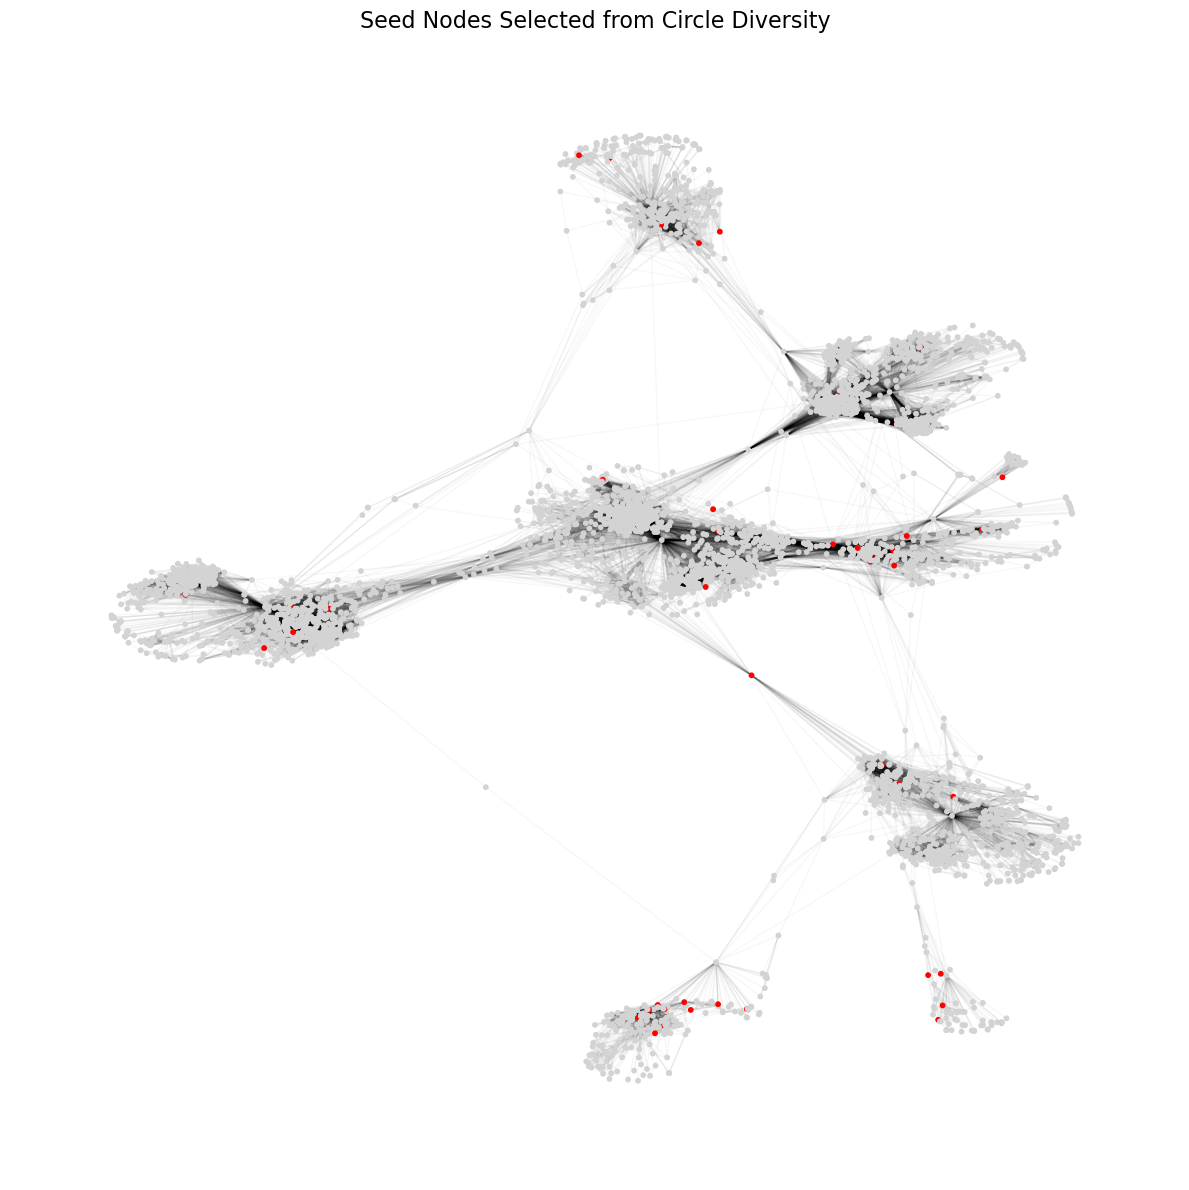

In [12]:
# Read the full graph (facebook_combined.txt)
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)
seeds = list(final_seed_set)

# Visualization (highlight seed nodes)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

# Node color: red for selected seeds, light gray for others
node_colors = ["red" if n in seeds else "lightgray" for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.03)

plt.title("Seed Nodes Selected from Circle Diversity", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


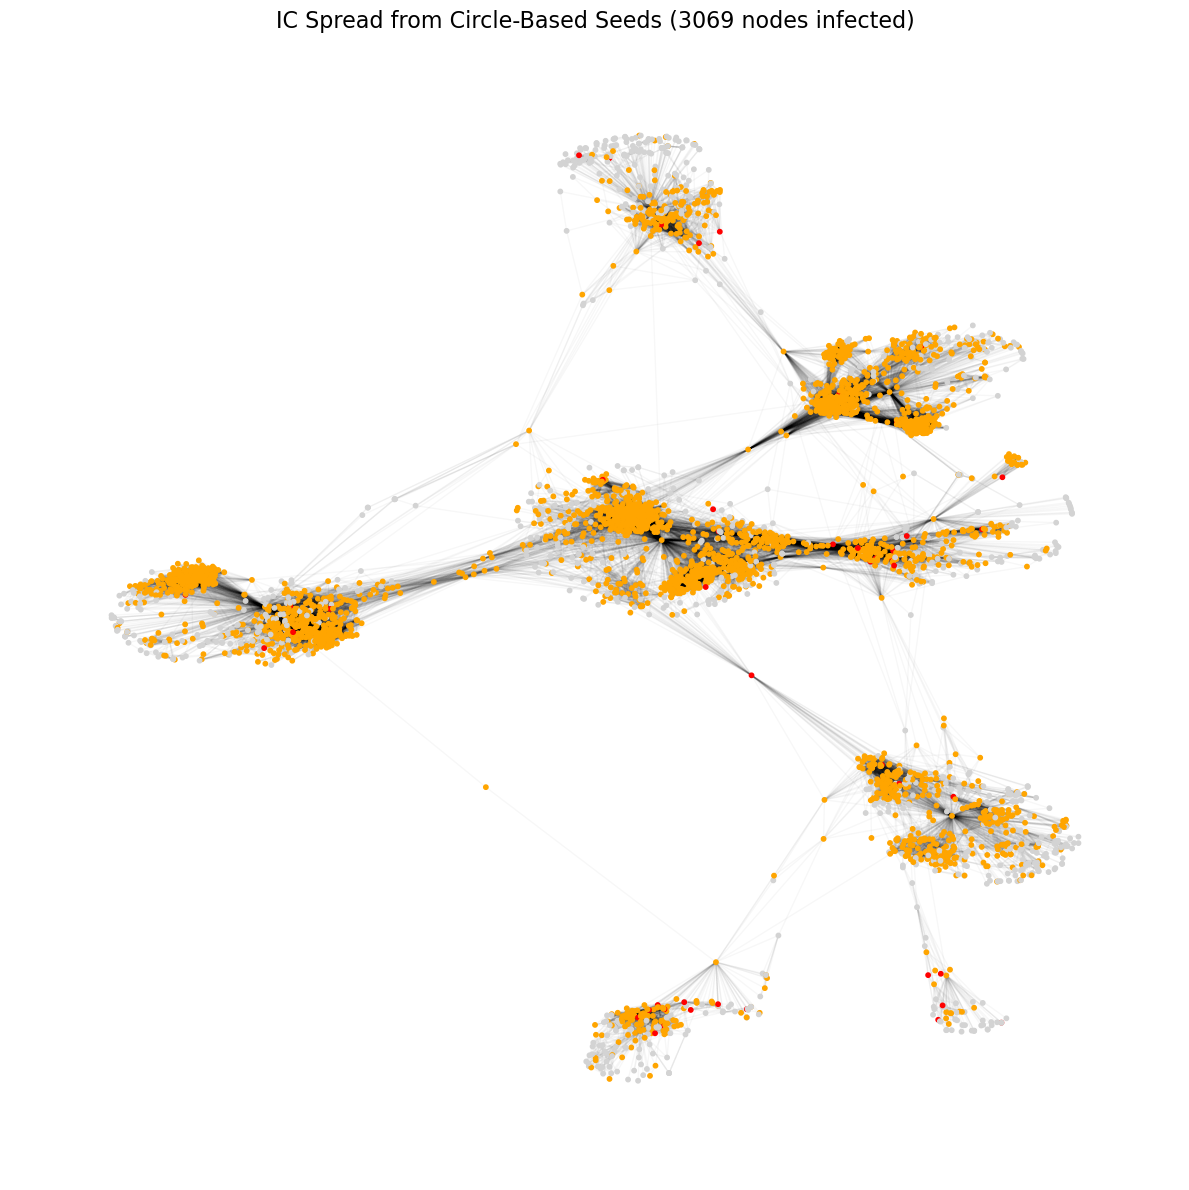

In [13]:
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.neighbors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

# one time propogation
infected = run_ic_once(G, seeds, p=0.1)

# visualize
plt.figure(figsize=(12, 12))
node_colors = []
for n in G.nodes():
    if n in seeds:
        node_colors.append("red")
    elif n in infected:
        node_colors.append("orange")
    else:
        node_colors.append("lightgray")

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.03)

plt.title(f"IC Spread from Circle-Based Seeds ({len(infected)} nodes infected)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


# Circle-based

In [16]:
# === Parameter settings ===
data_path = "facebook"
ego_ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
max_seeds_per_ego = 4
p = 0.1
steps = 100

# === Construct seed set (total 40 nodes) ===
final_seed_set = set()

for ego_id in ego_ids:
    # Load features
    feat = np.loadtxt(f"{data_path}/{ego_id}.feat")
    node_ids = feat[:, 0].astype(int)
    features = feat[:, 1:]
    ego_feat = np.loadtxt(f"{data_path}/{ego_id}.egofeat").astype(int)
    features = np.vstack([ego_feat, features])
    node_ids = np.concatenate([[ego_id], node_ids])
    activity = {nid: np.sum(features[i]) for i, nid in enumerate(node_ids)}

    # Load circles
    circle_map = defaultdict(list)
    with open(f"{data_path}/{ego_id}.circles") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 1:
                cname, *members = parts
                circle_map[cname] = list(map(int, members))

    # Select one representative node from each circle
    selected = []
    for cname, members in sorted(circle_map.items(), key=lambda x: -len(x[1])):
        candidates = sorted(members, key=lambda x: activity.get(x, 0), reverse=True)
        for u in candidates:
            if u not in final_seed_set:
                final_seed_set.add(u)
                selected.append(u)
                break
        if len(selected) >= max_seeds_per_ego:
            break

# === Output final seed nodes
seeds = sorted(final_seed_set)
print(f"\n Selected {len(seeds)} circle-diverse seeds:")
print(seeds)

# === IC spread simulation function
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.neighbors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

# === Load the full graph and run multiple IC simulations
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)
all_spreads = [len(run_ic_once(G, seeds, p)) for _ in range(steps)]
avg_spread = np.mean(all_spreads)
coverage = avg_spread / G.number_of_nodes() * 100

print(f"\n IC Spread from Circle-Based 40 Seeds")
print(f"Avg Infected: {avg_spread:.2f} / {G.number_of_nodes()}")
print(f"Coverage: {coverage:.2f}%")



✅ Selected 40 circle-diverse seeds:
[71, 80, 252, 339, 367, 428, 439, 523, 569, 579, 604, 647, 713, 747, 755, 774, 804, 828, 856, 888, 1029, 1085, 1549, 1568, 1875, 1985, 2128, 2199, 2325, 2825, 3010, 3313, 3349, 3521, 3586, 3677, 3986, 4002, 4004, 4030]

🎯 IC Spread from Circle-Based 40 Seeds
Avg Infected: 3066.60 / 4039
Coverage: 75.92%


# Circle+IMM

In [19]:
# === Parameter settings ===
data_path = "facebook"
ego_ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
max_seeds_per_ego = 8     # Select up to 8 representative nodes per ego (total 80)
num_seeds = 40            # IMM target output number of seeds
steps = 100               # Number of IC simulation steps
p = 0.1                   # Propagation probability

# === Step 1: Collect candidate nodes from ego circle representatives
final_seed_pool = set()

for ego_id in ego_ids:
    feat = np.loadtxt(f"{data_path}/{ego_id}.feat")
    node_ids = feat[:, 0].astype(int)
    features = feat[:, 1:]
    ego_feat = np.loadtxt(f"{data_path}/{ego_id}.egofeat").astype(int)
    features = np.vstack([ego_feat, features])
    node_ids = np.concatenate([[ego_id], node_ids])
    activity = {nid: np.sum(features[i]) for i, nid in enumerate(node_ids)}

    circle_map = defaultdict(list)
    with open(f"{data_path}/{ego_id}.circles") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 1:
                cname, *members = parts
                circle_map[cname] = list(map(int, members))

    selected = []
    for cname, members in sorted(circle_map.items(), key=lambda x: -len(x[1])):
        members_sorted = sorted(members, key=lambda x: activity.get(x, 0), reverse=True)
        for u in members_sorted:
            if u not in final_seed_pool:
                final_seed_pool.add(u)
                selected.append(u)
                break
        if len(selected) >= max_seeds_per_ego:
            break

candidate_nodes = sorted(final_seed_pool)
print(f"Final candidate pool size: {len(candidate_nodes)}")

# === Step 2: Load the full graph + IMM over restricted candidates
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)
G = nx.DiGraph(G)

def generate_rr_set(G, start_node, p=0.1):
    rr = set()
    visited = set()
    frontier = {start_node}
    while frontier:
        new_frontier = set()
        for u in frontier:
            if u not in visited:
                visited.add(u)
                rr.add(u)
                for v in G.predecessors(u):
                    if random.random() <= p:
                        new_frontier.add(v)
        frontier = new_frontier
    return rr

def imm_limited(G, candidates, k, R=1000, p=0.1):
    rr_sets = [generate_rr_set(G, random.choice(list(G.nodes())), p) for _ in range(R)]
    node_coverage = {u: [] for u in candidates}
    for i, rr in enumerate(rr_sets):
        for u in rr:
            if u in node_coverage:
                node_coverage[u].append(i)
    covered = set()
    selected = []
    for _ in range(k):
        best = max(((u, len(set(idxs) - covered)) for u, idxs in node_coverage.items()), key=lambda x: x[1])[0]
        selected.append(best)
        covered.update(node_coverage[best])
        del node_coverage[best]  # Remove selected node to prevent duplication
    return selected

# === Step 3: IMM selects the best 40 seeds from candidates
hybrid_seeds = imm_limited(G, candidate_nodes, k=num_seeds, R=1000, p=p)
print(f"\n Hybrid IMM (from 80 circle-based candidates):")
print(hybrid_seeds)

# === Step 4: IC simulation over 100 trials
def run_ic_once(G, seeds, p=0.1):
    activated = set(seeds)
    frontier = set(seeds)
    while frontier:
        new_frontier = set()
        for u in frontier:
            for v in G.neighbors(u):
                if v not in activated and random.random() <= p:
                    activated.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
    return activated

spreads = [len(run_ic_once(G, hybrid_seeds, p=p)) for _ in range(steps)]
avg_spread = np.mean(spreads)
coverage = avg_spread / G.number_of_nodes() * 100

print(f"\n Spread Result (IMM over 80 candidates → top 40)")
print(f"Avg Infected: {avg_spread:.2f} / {G.number_of_nodes()}")
print(f"Coverage: {coverage:.2f}%")


✅ Final candidate pool size: 79

✅ Hybrid IMM (from 80 circle-based candidates):
[348, 713, 3521, 4004, 80, 3986, 3990, 647, 888, 2470, 33, 71, 206, 252, 258, 326, 339, 367, 419, 428, 439, 450, 455, 516, 523, 569, 579, 592, 604, 639, 707, 741, 745, 747, 755, 774, 776, 789, 804, 828]

 Spread Result (IMM over 80 candidates → top 40)
Avg Infected: 3075.41 / 4039
Coverage: 76.14%


## CELF

In [3]:
# Too slow to run in Jupyter, so switched to VSCode.